In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from evaluate import denoise
from utils.loaddataset import SoundfieldDatasetLoader
from utils.modelhandler import loadtrainedmodel
from utils.util import load_config_yaml

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Load config file
config_file_path = 'config.yml'
yaml_contents = load_config_yaml(config_file_path)
config = yaml_contents["eval"]

# Load dataset
loader = SoundfieldDatasetLoader(config["dataset"])
dataset = loader.load()
im_noise, im_true, im_mask = dataset[:]

Text(0.5, 1.0, 'True label')

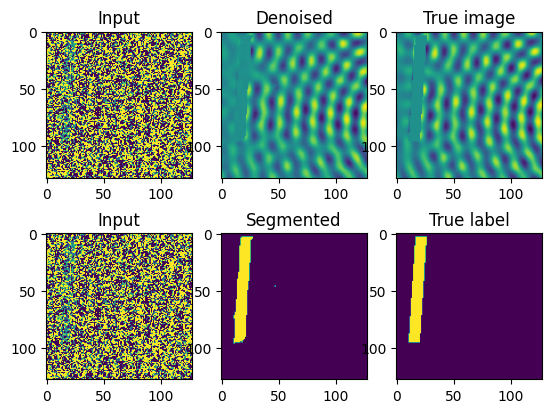

In [16]:
# Choose one data randomly
idx = np.random.randint(0, im_noise.shape[0])
im_n = im_noise[idx,...].unsqueeze(0)
im_t = im_true[idx,...].unsqueeze(0)
im_m = im_mask[idx,...].unsqueeze(0)

# Denoising and segmentation by DNN
net = loadtrainedmodel(config["network"]["model"], config["network"]["weights_file"]).to(device)
im_d, im_s = net(im_n.to(device))

# Applying sigmoid function and thresholding for segmented image
sig = nn.Sigmoid()
im_s = sig(im_s)
im_s = np.squeeze(im_s.cpu().detach().numpy()).astype(np.float32)
im_s[im_s>=0.5] = 1
im_s[im_s<0.5] = 0

# Torch to numpy
im_t = torch.squeeze(im_t).cpu().detach().numpy()
im_m = torch.squeeze(im_m).cpu().detach().numpy()
im_n = torch.squeeze(im_n).cpu().detach().numpy()
im_d = torch.squeeze(im_d).cpu().detach().numpy()


# Show images (real parts)
fig, axs = plt.subplots(2,3)
axs[0,0].imshow(im_n[0,...], vmin=-1, vmax=1)
axs[0,0].set_title("Input")
axs[0,1].imshow(im_d[0,...], vmin=-1, vmax=1)
axs[0,1].set_title("Denoised")
axs[0,2].imshow(im_t[0,...], vmin=-1, vmax=1)
axs[0,2].set_title("True image")
axs[1,0].imshow(im_n[0,...], vmin=-1, vmax=1)
axs[1,0].set_title("Input")
axs[1,1].imshow(im_s, vmin=0, vmax=1)
axs[1,1].set_title("Segmented")
axs[1,2].imshow(im_m, vmin=0, vmax=1)
axs[1,2].set_title("True label")


In [12]:
im_m.shape

(128, 128)